<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from mantisshrimp.all import *

In [2]:
source = Path('/home/lgvaz/.data/PennFudanPed/')

In [3]:
class PersonImageParser(ImageParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        # Get size
        sz = self.lines.filter(lambda o: o.startswith('Image size (X x Y x C)'))[0]
        sz = re.search(r'\d{3,4}\sx\s\d{3,4}\sx\s3', sz).group()
        self.sz = lmap(int, sz.split('x'))
        
    def iid(self, o): return self.i
    def file_path(self, o):
        fp = self.lines.filter(lambda o: o.startswith('Image filename'))[0]
        fp = re.findall(r'"(.*)"', fp)[0]
        return self.source.parent/fp
    
    def width(self, o):  return self.sz[0]
    def height(self, o): return self.sz[1]

In [4]:
class PersonAnnotationParser(AnnotationParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        ln = self.lines.filter(lambda o: o.startswith('Objects with ground truth'))[0]
        self.n = int(re.findall('\d+', ln)[0])
        
    def iid(self, o): return self.i
    def oid(self, o): return [1]*self.n
    def iscrowd(self, o): return [0]*self.n
        
    def bbox(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Bounding box'))
        bboxes = []
        for bbox in lines:
            bbox = re.findall(r'(\d+,\s\d+)', bbox)
            bbox = lmap(lambda o: lmap(int, o.split(',')), bbox)
            bbox = np.array(bbox).flat
            bboxes.append(BBox.from_xyxy(*bbox))
        return bboxes
    
    def seg(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Pixel mask for object'))
        line = lines[0] # All lines contain the same mask
        fp = self.source.parent/re.findall(r'"(.+)"', line.split(':')[-1])[0]
        return MaskFile(fp)

In [5]:
class PersonParser(DataParser):
    def get_img_parser(self, o, source): return PersonImageParser(o, source)
    def get_annot_parser(self, o, source): return PersonAnnotationParser(o, source)

In [6]:
fns = get_files(source/'Annotation', extensions='.txt')

In [7]:
parser = PersonParser(fns, source)
records = parser.parse()


Removed 0 images that don't have annotations


In [8]:
r = records[0]

In [9]:
r.to_rcnn_target()['masks'].shape

torch.Size([2, 341, 371])

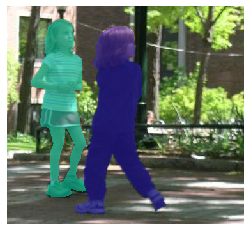

In [20]:
show_record(records[0])

> /home/lgvaz/git/mantisshrimp2/mantisshrimp/data/annotation.py(271)show_record()
-> if isinstance(ann.seg, Polygon):
(Pdb) ann.seg
MaskFile(fp=Path('/home/lgvaz/.data/PennFudanPed/PedMasks/PennPed00006_mask.png'))
(Pdb) isinstance(ann.seg, MaskFile)
True
(Pdb) n
> /home/lgvaz/git/mantisshrimp2/mantisshrimp/data/annotation.py(276)show_record()
-> elif isinstance(ann.seg, RLE):
(Pdb) n
> /home/lgvaz/git/mantisshrimp2/mantisshrimp/data/annotation.py(287)show_record()
-> elif isinstance(ann.seg, MaskFile):
(Pdb) n
> /home/lgvaz/git/mantisshrimp2/mantisshrimp/data/annotation.py(288)show_record()
-> m = ann.seg.to_mask(height, width).data
(Pdb) n
> /home/lgvaz/git/mantisshrimp2/mantisshrimp/data/annotation.py(289)show_record()
-> color_mask = np.random.random(3)
(Pdb) m
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0,

BdbQuit: 

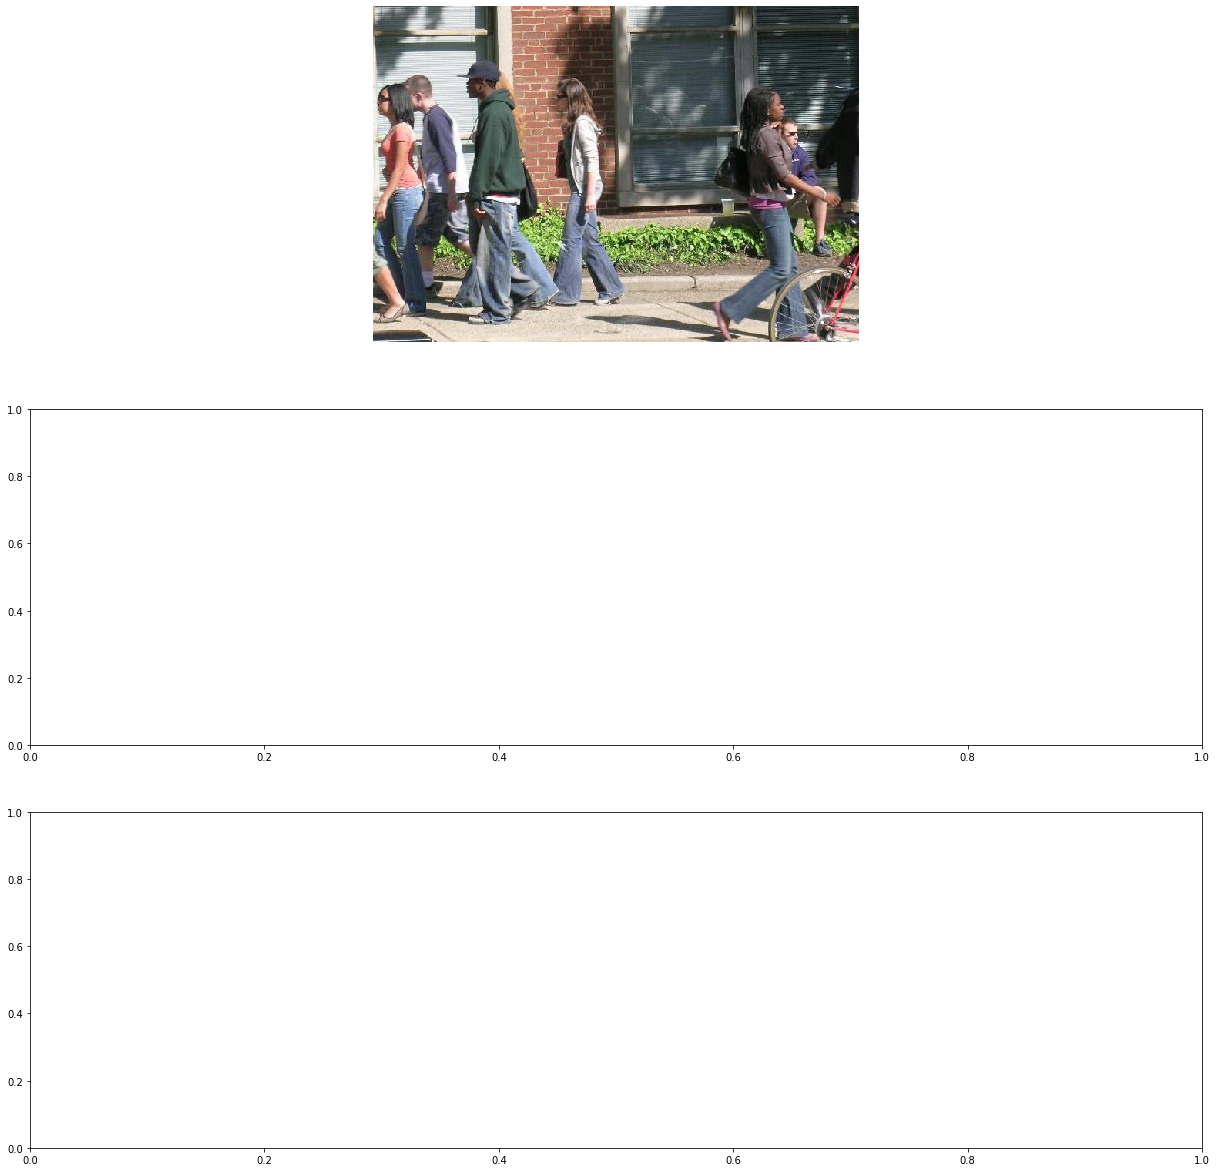

In [8]:
grid(partial(show_record, bbox=False), records[42:45])

In [9]:
fn = source.parent/'PennFudanPed/PedMasks/FudanPed00001_mask.png'

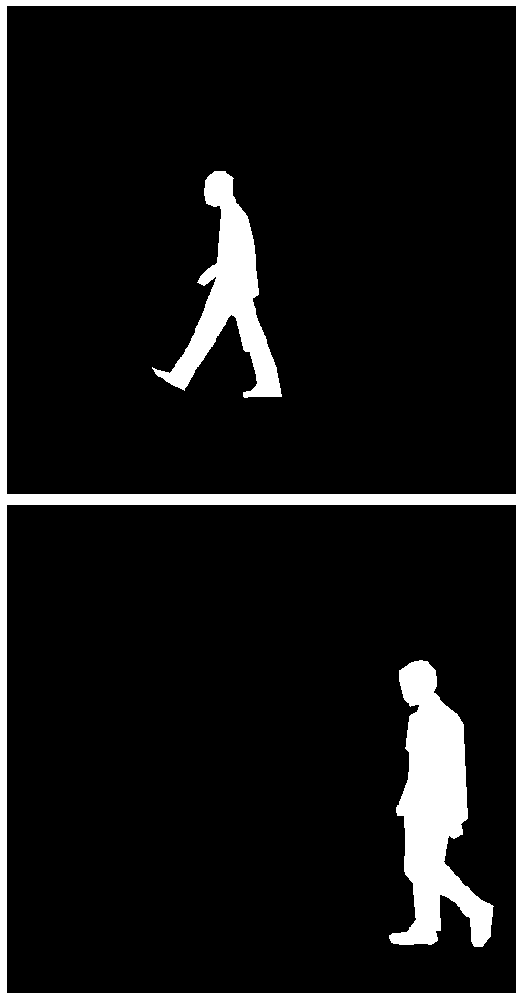

In [24]:
grid(show_img, masks)

In [11]:
mask.max()

2

In [25]:
import PIL

In [31]:
pilim = PIL.Image.open(fn).convert('L')

In [33]:
np.array(pilim).shape

(536, 559)

In [24]:
mask[...,2].max()

2